# 1 Import the libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import PIL

# 2 Load the data

## 2.1 Data Load

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_directory = os.path.join(PATH, 'train')
validation_directory = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMAGE_SIZE = (160, 160)

In [4]:
train_set = keras.preprocessing.image_dataset_from_directory(train_directory,
                                                             shuffle=True,
                                                             batch_size=BATCH_SIZE,
                                                             image_size=IMAGE_SIZE)

Found 2000 files belonging to 2 classes.


In [5]:
validation_set = keras.preprocessing.image_dataset_from_directory(validation_directory,
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMAGE_SIZE)

Found 1000 files belonging to 2 classes.


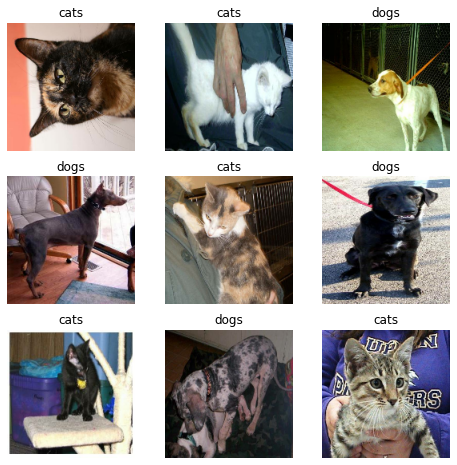

In [6]:
class_names = train_set.class_names

plt.figure(figsize=(8,8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

#### Split between validation and test set 50/50

In [7]:
validation_batches = tf.data.experimental.cardinality(validation_set)
test_set = validation_set.take(validation_batches // 2)
validation_set = validation_set.skip(validation_batches // 2)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of validation batches: 16
Number of test batches: 16


## 2.2 Configure the dataset for performance

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)
test_set = test_set.prefetch(buffer_size=AUTOTUNE)

## 2.3 Use Data Augmentation

In [10]:
data_augmentation = keras.models.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

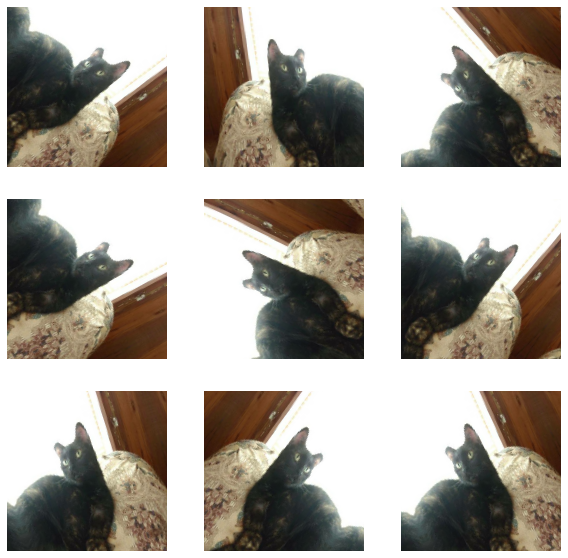

In [11]:
for image, _ in train_set.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(image[0], 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 2.4 Rescale pixel values

In [12]:
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [13]:
rescale = keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

# 3.Build the model

## 3.1 Create the base model from the pretrained convnets

In [14]:
#Create the base model from the pre-trained model MobileNet V2
IMAGE_SHAPE = IMAGE_SIZE + (3,)

base_model = keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [15]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

## 3.2 Feature Extraction

### 3.2.1 Freeze the convolutional base

In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### 3.2.3 Add a classification head

In [18]:
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 1280])

In [19]:
prediction_layer = keras.layers.Dense(196)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch.shape

TensorShape([32, 196])

## 3.3 Concate the model

In [21]:
inputs = keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)   #Batch Normalization
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = keras.Model(inputs, outputs)

# 4.Compile the model

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [26]:
len(model.trainable_variables)

2

# 5.Train the model

In [27]:
loss0, accuracy0 = model.evaluate(validation_set)

16/16 [==============================] - 23s 527ms/step - loss: 6.5717 - accuracy: 0.0000e+00


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.58
initial accuracy: 0.00


In [37]:
initial_epochs = 10
history = model.fit(train_set,
          epochs=initial_epochs,
          validation_data=validation_set)

Epoch 1/10
63/63 [==============================] - 88s 1s/step - loss: 0.5730 - accuracy: 0.7389 - val_loss: 0.1205 - val_accuracy: 0.9652
Epoch 2/10
63/63 [==============================] - 76s 1s/step - loss: 0.2761 - accuracy: 0.8902 - val_loss: 0.0942 - val_accuracy: 0.9693
Epoch 3/10
63/63 [==============================] - 75s 1s/step - loss: 0.2396 - accuracy: 0.9058 - val_loss: 0.0753 - val_accuracy: 0.9775
Epoch 4/10
63/63 [==============================] - 75s 1s/step - loss: 0.1864 - accuracy: 0.9236 - val_loss: 0.0705 - val_accuracy: 0.9775
Epoch 5/10
63/63 [==============================] - 70s 1s/step - loss: 0.1858 - accuracy: 0.9194 - val_loss: 0.0604 - val_accuracy: 0.9795
Epoch 6/10
63/63 [==============================] - 57s 884ms/step - loss: 0.1865 - accuracy: 0.9197 - val_loss: 0.0552 - val_accuracy: 0.9775
Epoch 7/10
63/63 [==============================] - 49s 763ms/step - loss: 0.1592 - accuracy: 0.9372 - val_loss: 0.0591 - val_accuracy: 0.9775
Epoch 8/10
63/

# 6.Evaluate the model 

## 6.1 Learning Curves

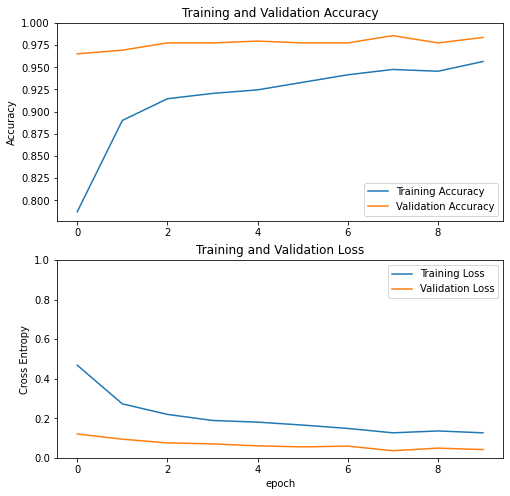

In [38]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 6.2 Fine-tuning

### 6.2.1 Unfreeze the top layers of the model

In [39]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


### 6.2.2 Compile the model

In [41]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [43]:
len(model.trainable_variables)

56

### 6.2.3 Continue training the model

In [44]:
fine_tune_epochs = 10
total_epochs = fine_tune_epochs + initial_epochs

history_fine = model.fit(train_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set)

Epoch 10/20
63/63 [==============================] - 53s 763ms/step - loss: 0.1312 - accuracy: 0.9476 - val_loss: 0.0432 - val_accuracy: 0.9836
Epoch 11/20
63/63 [==============================] - 48s 747ms/step - loss: 0.1197 - accuracy: 0.9516 - val_loss: 0.0367 - val_accuracy: 0.9898
Epoch 12/20
63/63 [==============================] - 48s 758ms/step - loss: 0.1069 - accuracy: 0.9524 - val_loss: 0.0463 - val_accuracy: 0.9836
Epoch 13/20
63/63 [==============================] - 49s 764ms/step - loss: 0.1186 - accuracy: 0.9506 - val_loss: 0.0469 - val_accuracy: 0.9877
Epoch 14/20
63/63 [==============================] - 48s 750ms/step - loss: 0.0758 - accuracy: 0.9743 - val_loss: 0.0432 - val_accuracy: 0.9836
Epoch 15/20
63/63 [==============================] - 49s 766ms/step - loss: 0.1165 - accuracy: 0.9464 - val_loss: 0.0465 - val_accuracy: 0.9795
Epoch 16/20
63/63 [==============================] - 48s 754ms/step - loss: 0.0955 - accuracy: 0.9576 - val_loss: 0.0452 - val_accuracy:

In [45]:
accuracy += history_fine.history['accuracy']
validation_accuracy += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
validation_loss += history_fine.history['val_loss']

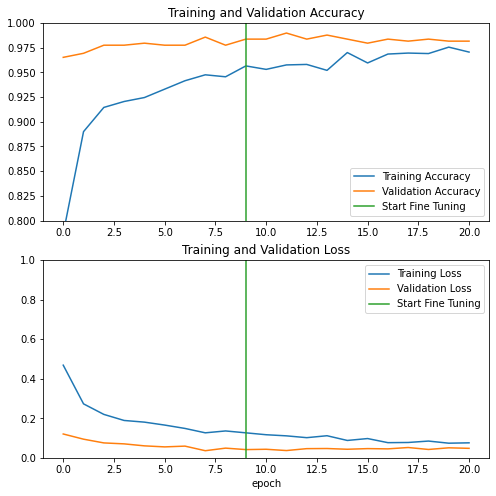

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 7.Evaluation and Prediction

In [47]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy: ', accuracy)

16/16 [==============================] - 6s 349ms/step - loss: 0.0519 - accuracy: 0.9844
Test accuracy:  0.984375


Predictions:
 [0 1 0 ... 0 0 0]
Labels:
 [1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1]


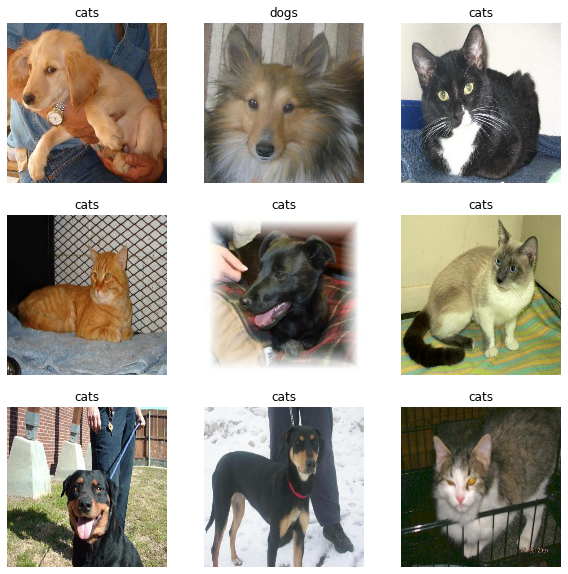

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_set.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# 8.Save the model

In [49]:
model.save('cat_vs_dog_classification.h5')

In [50]:
pre_model = keras.models.load_model('cat_vs_dog_classification.h5')
pre_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [52]:
test_loss, test_accuracy = model.evaluate(test_set, verbose=2)
print('The restored model\'s accuracy: ', test_accuracy)

16/16 - 6s - loss: 0.0505 - accuracy: 0.9844
The restored model's accuracy:  0.984375
